# Siamese Networks

## Imports

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Function to draw

In [2]:
def imgshow(img,text=None,should_save=False):
    img_np = img.numpy()
    plt.axis("off")  # 关掉轴线
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    plt.show()    

def show_plot(it,loss):  # iteration，loss图表
    plt.plot(it,loss)
    plt.show()

## Confuration

In [3]:
class Conf():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Datasets
50%的概率取到同一个人 50%取到不同的人

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_and_position = random.choice(self.imageFolderDataset.imgs)
        
        is_same = random.randint(0,1) 
        cnt = 0
        if is_same:
            while True:
                cnt += 1 
                # 找到一组相同人的图片
                img1_and_position = random.choice(self.imageFolderDataset.imgs) 
                if img0_and_position[1]==img1_and_position[1]:
                    break
                
                # 防止进入死循环
                if cnt >= 20:
                    break
        else:
            while True:
                cnt += 1
                # 找到一组不同人的图片
                
                img1_and_position = random.choice(self.imageFolderDataset.imgs) 
                if img0_and_position[1] !=img1_and_position[1]:
                    break
                if cnt >= 20:
                    break

        img0 = Image.open(img0_and_position[0])
        img1 = Image.open(img1_and_position[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_and_position[1]!=img0_and_position[1])],dtype=np.float32))
#         return img0, img1 , torch.from_numpy(np.array([int(is_same)],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Load data from folder

In [5]:
folder_dataset = datasets.ImageFolder(root=Conf.training_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
##### in one pair, the same person for 0, the different person for 1

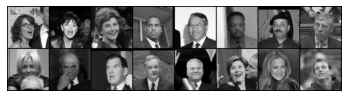

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imgshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Build a convolutional neural network

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [9]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training part

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Conf.train_batch_size)

In [7]:
net = SiameseNetwork()
# criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [12]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.9318253993988037

Epoch number 0
 Current loss 7.182391166687012

Epoch number 0
 Current loss 4.901795864105225

Epoch number 0
 Current loss 0.5694043040275574

Epoch number 1
 Current loss 6.355595111846924

Epoch number 1
 Current loss 0.39021220803260803

Epoch number 1
 Current loss 0.28417569398880005

Epoch number 1
 Current loss 0.34577393531799316

Epoch number 2
 Current loss 1.519463062286377

Epoch number 2
 Current loss 1.076696515083313

Epoch number 2
 Current loss 0.35685649514198303

Epoch number 2
 Current loss 0.5468252301216125

Epoch number 3
 Current loss 0.5176936984062195

Epoch number 3
 Current loss 0.44115233421325684

Epoch number 3
 Current loss 0.3017217516899109

Epoch number 3
 Current loss 1.093371033668518

Epoch number 4
 Current loss 0.4951266050338745

Epoch number 4
 Current loss 1.0788862705230713

Epoch number 4
 Current loss 0.3895943760871887

Epoch number 4
 Current loss 0.25322583317756653

Epoch number 5
 Curr

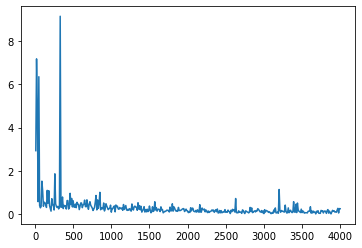

In [13]:
for epoch in range(0,Conf.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [9]:
net.load_state_dict(torch.load("net_state_dict.pt", map_location=torch.device("cpu")))

<All keys matched successfully>

## Testing
#### The Distance between each image pair denotes the degree of similarity. Less means more similar

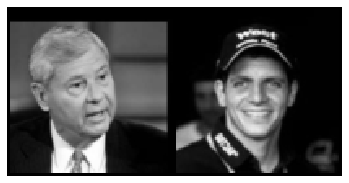

Dissimilarity: 3.7050
label: the defferent people


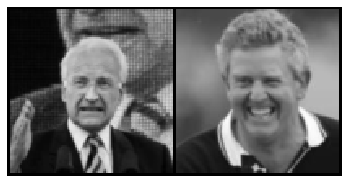

Dissimilarity: 2.0214
label: the defferent people


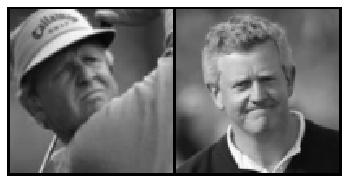

Dissimilarity: 1.3946
label: the same people


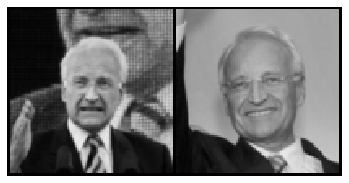

Dissimilarity: 1.8169
label: the same people


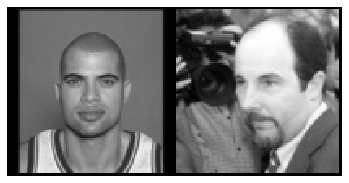

Dissimilarity: 1.4073
label: the defferent people


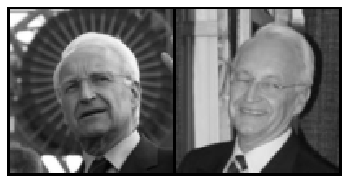

Dissimilarity: 0.9558
label: the same people


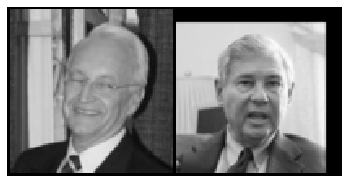

Dissimilarity: 1.5914
label: the defferent people


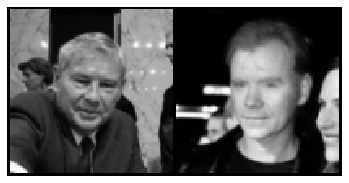

Dissimilarity: 2.2403
label: the defferent people


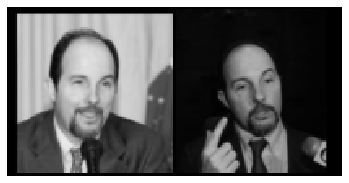

Dissimilarity: 1.1752
label: the same people


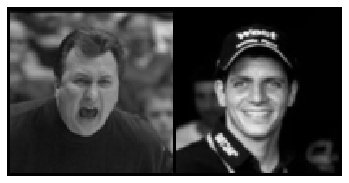

Dissimilarity: 1.7574
label: the defferent people


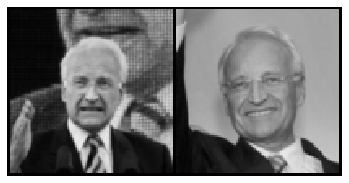

Dissimilarity: 1.8169
label: the same people


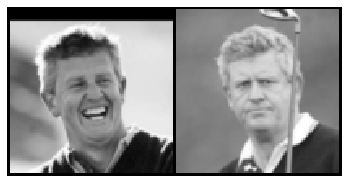

Dissimilarity: 2.6595
label: the same people


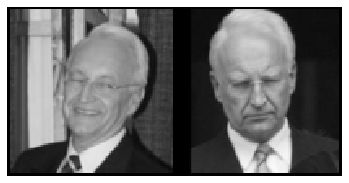

Dissimilarity: 1.1794
label: the same people


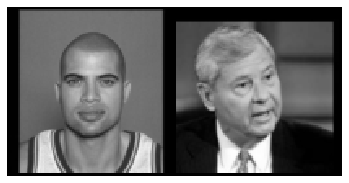

Dissimilarity: 2.5246
label: the defferent people


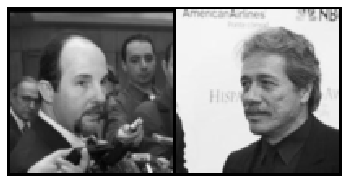

Dissimilarity: 2.8931
label: the defferent people


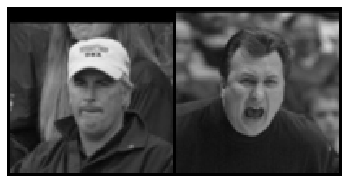

Dissimilarity: 2.3932
label: the defferent people


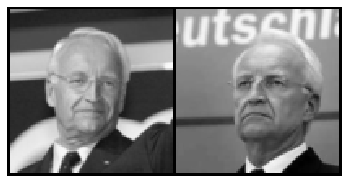

Dissimilarity: 1.5900
label: the same people


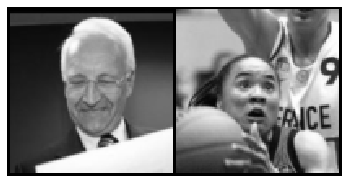

Dissimilarity: 3.3247
label: the defferent people


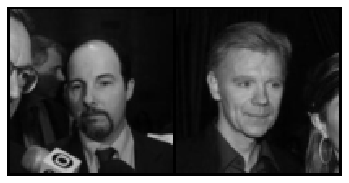

Dissimilarity: 1.5588
label: the defferent people


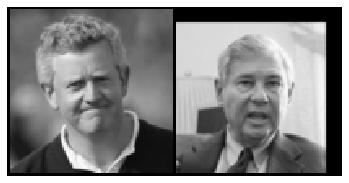

Dissimilarity: 1.6015
label: the defferent people


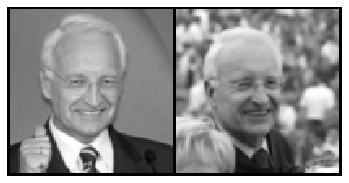

Dissimilarity: 1.4443
label: the same people


In [12]:
folder_dataset_test = datasets.ImageFolder(root=Conf.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

cnt = 0
while True:
    if cnt > 20:
        break
    A,x1,label2 = next(dataiter)
    concatenated = torch.cat((A,x1),0)
    
    output1,output2 = net(Variable(A),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    if(euclidean_distance < 0.00001):
        continue
    imgshow(torchvision.utils.make_grid(concatenated))
    print("Dissimilarity: {:.4f}".format(euclidean_distance.item()) )
    if(int(label2.numpy()[0,0]) == 0):
        print("label: the same people")
    else:
        print("label: the defferent people")
    cnt += 1
